In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score
from sklearn.externals import joblib

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from scipy import sparse
import xgboost as xgb
from pathlib import Path

import re
from tqdm.auto import tqdm

from wordcloud import WordCloud
import spacy

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
tqdm.pandas()
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = Path('..')/'data/processed'

df = pd.read_csv(path/'90_day_data_postprocessed_no_hospital_deaths.csv')

In [4]:
cv = CountVectorizer(analyzer=str.split,ngram_range=(1,2),stop_words=None,lowercase=False,max_features=10000,max_df=0.9,min_df=1e-4)
X_counts = cv.fit_transform(df.text_processed)
tfidf_tr = TfidfTransformer()
X_tfidf = tfidf_tr.fit_transform(X_counts)
print(X_tfidf.shape)

(47805, 10000)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_tfidf, df['labels'],test_size=0.2)
#X_train_bal,y_train_bal = SMOTE().fit_sample(X_train,y_train)
X_train_bal,y_train_bal = RandomUnderSampler().fit_sample(X_train,y_train)
print('original training set size: ',len(y_train))
print('new training set size: ',len(y_train_bal))
print('number of negative samples: ',len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ',len(y_train_bal[y_train_bal==1]))

original training set size:  38244
new training set size:  13660
number of negative samples:  6830
number of positive samples:  6830


In [7]:
def get_scores(y_train,yhat_train,y_test,yhat_test):
    print('--Training Set Scores--')
    print('accuracy: ', round(accuracy_score(y_train,yhat_train),4))
    print('precision: ', round(precision_score(y_train,yhat_train),4))
    print('recall: ', round(recall_score(y_train,yhat_train),4))
    print('f1: ', round(f1_score(y_train,yhat_train),4))
    print('auc: ', round(roc_auc_score(y_train,yhat_train),4))
    print('confusion matrix:\n', confusion_matrix(y_train,yhat_train))
    print()
    print('--Test Set Scores--')
    print('accuracy: ', round(accuracy_score(y_test,yhat_test),4))
    print('precision: ', round(precision_score(y_test,yhat_test),4))
    print('recall: ', round(recall_score(y_test,yhat_test),4))
    print('f1: ', round(f1_score(y_test,yhat_test),4))
    print('auc: ', round(roc_auc_score(y_test,yhat_test),4))
    print('confusion matrix:\n', confusion_matrix(y_test,yhat_test))
    
def plot_feature_importances(model,vectorizer,model_type='rf',max_num=10):
    if model_type in ['rf','xgb']:
        importances = model.feature_importances_
    if model_type == 'lr':
        importances = np.abs(model.coef_).flatten()
    
    str_to_int = vectorizer.vocabulary_
    int_to_str = {val:key for key,val in str_to_int.items()}
    
    top_importances = -np.sort(-importances)[:max_num]
    top_importances = np.sort(top_importances)
    
    #std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    
    top_features = np.argsort(-importances)[:max_num]
    top_words = [int_to_str[i] for i in top_features]
    top_words = reversed(top_words)
    
    plt.figure()
    plt.title('Feature importances')
    plt.barh(range(max_num), top_importances,
             color='r', align='center')
    plt.yticks(range(max_num), top_words)
    plt.ylim([-1, max_num])
    plt.show()

--Training Set Scores--
accuracy:  0.7473
precision:  0.7384
recall:  0.766
f1:  0.7519
auc:  0.7473
confusion matrix:
 [[4976 1854]
 [1598 5232]]

--Test Set Scores--
accuracy:  0.6873
precision:  0.3276
recall:  0.7212
f1:  0.4506
auc:  0.7006
confusion matrix:
 [[5345 2516]
 [ 474 1226]]


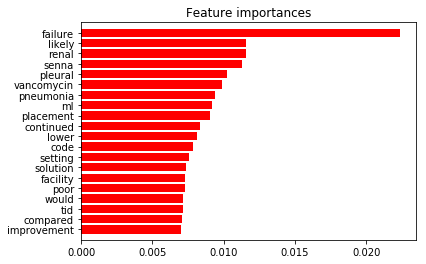

In [8]:
model_rf = RandomForestClassifier(n_estimators=60,min_samples_leaf=50,max_features='auto',min_samples_split=5,n_jobs=-1)
model_rf.fit(X_train_bal,y_train_bal)

yhat_train_rf = model_rf.predict(X_train_bal)
yhat_test_rf = model_rf.predict(X_test)
get_scores(y_train_bal,yhat_train_rf,y_test,yhat_test_rf)

plot_feature_importances(model_rf,cv,model_type='rf',max_num=20)

--Training Set Scores--
accuracy:  0.7897
precision:  0.7879
recall:  0.7928
f1:  0.7903
auc:  0.7897
confusion matrix:
 [[5372 1458]
 [1415 5415]]

--Test Set Scores--
accuracy:  0.7257
precision:  0.366
recall:  0.7418
f1:  0.4902
auc:  0.732
confusion matrix:
 [[5677 2184]
 [ 439 1261]]


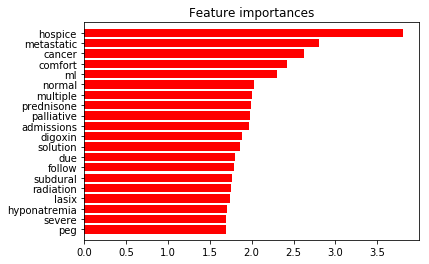

In [11]:
model_lr = LogisticRegression(C=1.)
model_lr.fit(X_train_bal,y_train_bal)

yhat_train_lr = model_lr.predict(X_train_bal)
yhat_test_lr = model_lr.predict(X_test)
get_scores(y_train_bal,yhat_train_lr,y_test,yhat_test_lr)

plot_feature_importances(model_lr,cv,model_type='lr',max_num=20)

--Training Set Scores--
accuracy:  0.7225
precision:  0.7264
recall:  0.7138
f1:  0.72
auc:  0.7225
confusion matrix:
 [[4994 1836]
 [1955 4875]]

--Test Set Scores--
accuracy:  0.7201
precision:  0.3543
recall:  0.6982
f1:  0.4701
auc:  0.7115
confusion matrix:
 [[5698 2163]
 [ 513 1187]]


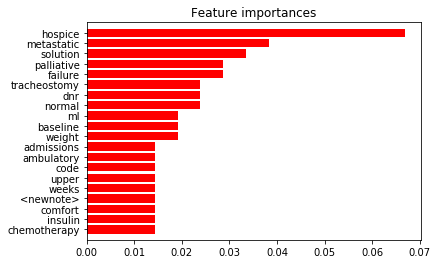

In [12]:
import warnings; warnings.filterwarnings('ignore')

model_xgb = xgb.XGBClassifier(n_estimators=30,n_jobs=8)
model_xgb.fit(X_train_bal,y_train_bal)

yhat_train_xgb = model_xgb.predict(X_train_bal)
yhat_test_xgb = model_xgb.predict(X_test)
get_scores(y_train_bal,yhat_train_xgb,y_test,yhat_test_xgb)

plot_feature_importances(model_xgb,cv,model_type='xgb',max_num=20)

In [13]:
yhat_train_ensemble = np.median([yhat_train_rf,yhat_train_lr,yhat_train_xgb],axis=0)
yhat_test_ensemble = np.median([yhat_test_rf,yhat_test_lr,yhat_test_xgb],axis=0)
get_scores(y_train_bal,yhat_train_ensemble,y_test,yhat_test_ensemble)

--Training Set Scores--
accuracy:  0.7558
precision:  0.7519
recall:  0.7635
f1:  0.7577
auc:  0.7558
confusion matrix:
 [[5109 1721]
 [1615 5215]]

--Test Set Scores--
accuracy:  0.7153
precision:  0.3539
recall:  0.7282
f1:  0.4763
auc:  0.7204
confusion matrix:
 [[5601 2260]
 [ 462 1238]]


In [14]:
warnings.filterwarnings('ignore')

yhat_test = np.zeros(y_test.shape)
get_scores(y_test,yhat_test,y_test,yhat_test)

--Training Set Scores--
accuracy:  0.8222
precision:  0.0
recall:  0.0
f1:  0.0
auc:  0.5
confusion matrix:
 [[7861    0]
 [1700    0]]

--Test Set Scores--
accuracy:  0.8222
precision:  0.0
recall:  0.0
f1:  0.0
auc:  0.5
confusion matrix:
 [[7861    0]
 [1700    0]]


(array([ 460.,  871., 1638., 1575., 1345., 1203., 1019.,  757.,  555.,
         138.]),
 array([0.07445992, 0.15683269, 0.23920547, 0.32157824, 0.40395101,
        0.48632378, 0.56869655, 0.65106932, 0.73344209, 0.81581486,
        0.89818763]),
 <a list of 10 Patch objects>)

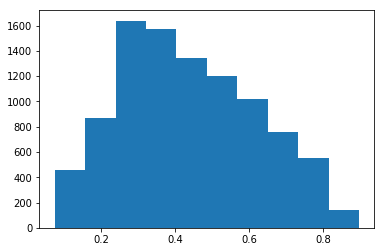

In [18]:
pred_probs = np.mean([model_rf.predict_proba(X_test),model_lr.predict_proba(X_test),model_xgb.predict_proba(X_test)],
                       axis=0)
plt.hist(pred_probs[:,1])

In [ ]:
model_svm = SVC(C=1.,kernel='linear')
model_svm.fit(X_train_bal,y_train_bal)

yhat_train_svm = model_svm.predict(X_train_bal)
yhat_test_svm = model_svm.predict(X_test)
get_scores(y_train_bal,yhat_train_svm,y_test,yhat_test_svm)

# plot_feature_importances(model,cv,model_type='lr',max_num=20)